In [1]:
from sklearn.svm import SVC, LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, classification_report
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.naive_bayes import MultinomialNB
import sys
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
import joblib
from sklearn.metrics import confusion_matrix
from sklearn.feature_selection import SelectKBest,chi2
from collections import Counter
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.base import TransformerMixin, BaseEstimator

plt.style.use("ggplot")

In [2]:
feature_scores = []

In [3]:
class FeatureSelector(BaseEstimator, TransformerMixin):

    def __init__(self, feature_count):
        self.feature_count = feature_count
        self.transformer = None

    def fit(self, X, y=None):
        self.transformer  = SelectKBest(chi2, k = self.feature_count)
        self.transformer.fit(X, y)
        return self

    def transform(self, X, y = None):
        feature_scores.append(self.transformer.scores_)
        return self.transformer.transform(X)

In [8]:
class ModelSelector:

    def __init__(self, clf_opt):
        self.clf_opt = clf_opt
        self.path = "preprocessed/train.csv"
        self.no_of_selected_features = 50

    def classification_pipeline(self):

        # AdaBoost
        if self.clf_opt == 'ab':

            print('\n\t### Training AdaBoost Classifier ### \n')

            be1 = SVC(kernel='linear', class_weight='balanced', probability=True)
            be2 = LogisticRegression(solver='liblinear', class_weight='balanced')
            be3 = DecisionTreeClassifier(max_depth=50)

            clf = AdaBoostClassifier(algorithm='SAMME.R', n_estimators=100)
            clf_parameters = {
                'clf__base_estimator':(be1, be2, be3),
                'clf__random_state':(0, 10),
            }

        # Decision Tree
        elif self.clf_opt =='dt':

            print('\n\t### Training Decision Tree Classifier ### \n')

            clf = DecisionTreeClassifier(random_state=40)
            clf_parameters = {
                'clf__criterion':('gini', 'entropy'),
                'clf__max_features':('auto', 'sqrt', 'log2'),
                'clf__max_depth':(10, 40, 45, 60),
                'clf__ccp_alpha':(0.009, 0.01, 0.05, 0.1),
            }

        # knn
        elif self.clf_opt =='knn':

            print('\n\t### Training K nearest neighbour classifier ### \n')

            clf = KNeighborsClassifier(metric= 'minkowski')
            clf_parameters = {
                'clf__n_neighbors' : (5, 10, 25, 50, 100),
                'clf__weights' : ('uniform','distance'),
                'clf__p' : (1, 2)
            }


        # Logistic Regression
        elif self.clf_opt=='lr':

            print('\n\t### Training Logistic Regression Classifier ### \n')

            clf = LogisticRegression(solver='liblinear', class_weight='balanced')
            clf_parameters = {
                'clf__random_state':(0, 42),
                'clf__C':(0.01, 0.1, 1)
            }

        # Linear SVC
        elif self.clf_opt=='ls':

            print('\n\t### Training Linear SVC Classifier ### \n')

            clf = LinearSVC(class_weight='balanced', max_iter = 2000)

            clf_parameters = {
                'clf__C':(0.01, 0.1, 1, 100),
            }

        # Multinomial Naive Bayes

        elif self.clf_opt =='nb':

            print('\n\t### Training Multinomial Naive Bayes Classifier ### \n')

            clf = MultinomialNB(fit_prior=True, class_prior=None)
            clf_parameters = {
                'clf__alpha': (0.01, 0.1, 1, 10, 100),
            }

        # Random Forest
        elif self.clf_opt =='rf':
            print('\n\t ### Training Random Forest Classifier ### \n')
            clf = RandomForestClassifier(max_features=None, class_weight='balanced')
            clf_parameters = {
                'clf__criterion':('entropy', 'gini'),
                'clf__n_estimators':(30, 50, 100),
                'clf__max_depth':(10, 20, 30, 50, 100, 200),
            }

        # Support Vector Machine
        elif self.clf_opt=='svm':

            print('\n\t### Training SVM Classifier ### \n')

            clf = SVC(class_weight='balanced', probability=True)
            clf_parameters = {
                'clf__C':(1, 10),
                'clf__kernel':['poly'],
                # 'clf__C':(0.1, 1, 10),
                # 'clf__kernel':('rbf', 'poly', 'sigmoid'),

            }
        else:
            print('Select a valid classifier \n')
            sys.exit(0)
        return clf, clf_parameters

    def get_data(self):
        df = pd.read_csv(self.path)
        train_labels = pd.read_csv("raw/train_class_labels.csv")['income_>50K']
        return train_test_split(df.to_numpy(), train_labels, test_size=0.25)



    def classification(self):

        # Get the data
        trn_data, tst_data, trn_cat, tst_cat=self.get_data()

        clf,clf_parameters=self.classification_pipeline()
        pipeline = Pipeline([
            ('feature_selection', FeatureSelector(feature_count=self.no_of_selected_features) ),                         # k=1000 is recommended
            #       ('feature_selection', SelectKBest(mutual_info_classif, k=self.no_of_selected_features)),
            ('clf', clf),])
        grid = GridSearchCV(pipeline, clf_parameters, scoring='f1', cv=10, verbose = 4)
        grid.fit(trn_data, trn_cat)
        clf= grid.best_estimator_
        print('\n\n The best set of parameters of the pipeline are: ')
        print(clf)
        joblib.dump(clf, self.path+'trn_model.joblib')
        predicted=clf.predict(tst_data)
        # Evaluation
        class_names=list(Counter(tst_cat).keys())
        class_names = [str(x) for x in class_names]
        print('\n The classes are: ')
        print(class_names)
        # Evaluation
        print('\n *************** Confusion Matrix ***************  \n')
        print (confusion_matrix(tst_cat, predicted))
        # class_names = list(Counter(tst_cat).keys())
        class_names = [str(x) for x in list(Counter(tst_cat).keys())]
        print('\n **a*************  Scores on Test Data  *************** \n ')
        print(classification_report(tst_cat, predicted, target_names=class_names))
        print(roc_auc_score(tst_cat, predicted))

In [ ]:
mo = ModelSelector(clf_opt = 'rf')
mo.classification()


	 ### Training Random Forest Classifier ### 

Fitting 10 folds for each of 36 candidates, totalling 360 fits
[CV 1/10] END clf__criterion=entropy, clf__max_depth=10, clf__n_estimators=30;, score=0.653 total time=   2.7s
[CV 2/10] END clf__criterion=entropy, clf__max_depth=10, clf__n_estimators=30;, score=0.659 total time=   2.8s
[CV 3/10] END clf__criterion=entropy, clf__max_depth=10, clf__n_estimators=30;, score=0.681 total time=   3.2s


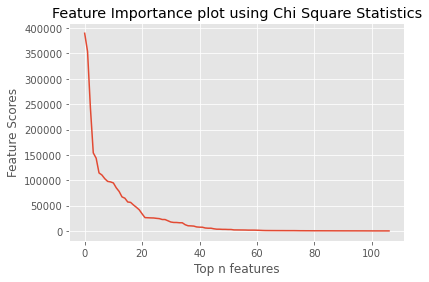

In [7]:
# plot the feature importance using Chi Square Statistic
plt.plot(np.sort(np.nan_to_num(np.asarray(feature_scores)).sum(axis = 0))[::-1])
plt.title("Feature Importance plot using Chi Square Statistics")
plt.xlabel("Top n features")
plt.ylabel("Feature Scores")
plt.show()